In [6]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_csv('data/neo.csv')

1. Initial Data Preparation 

Take a Quick Look at the Data Structure

In [9]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Check out the Categorical Columns

In [11]:
df['orbiting_body'].value_counts() 

orbiting_body
Earth    90836
Name: count, dtype: int64

In [12]:
df['sentry_object'].value_counts() 

sentry_object
False    90836
Name: count, dtype: int64

Since both 'orbiting_body' and 'sentry_object' don't have more than 1 directory, that renders them useless and we can remove them

In [13]:
prep_df = df.drop(columns=['id', 'name', 'orbiting_body', 'sentry_object'])
prep_df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


In [14]:
prep_df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


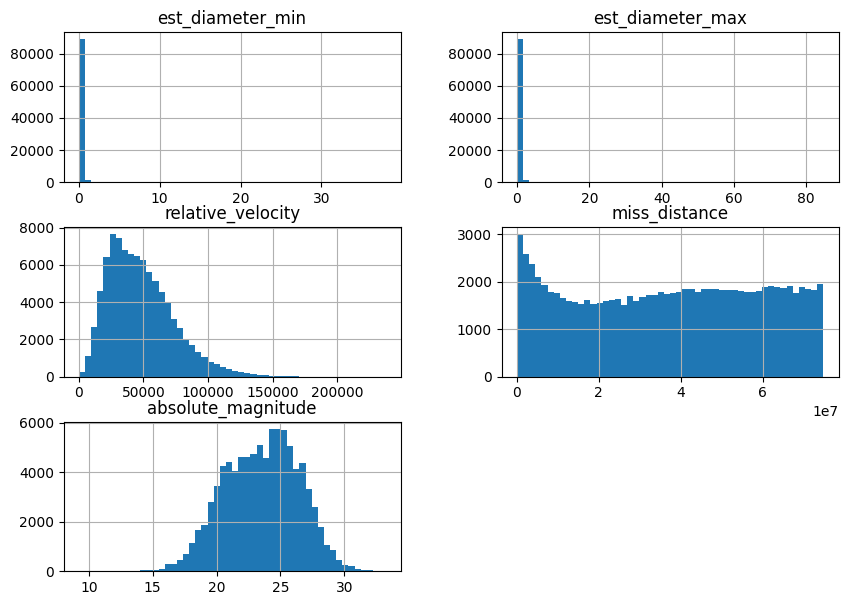

In [15]:
prep_df.hist(bins=50, figsize=(10,7))
plt.show()

No values seem to be capped, est_diameter_min/max definitely needs to be normalized to extract more info!

In [16]:
# Find if dataset is skewed
asteroid_count      = len(prep_df['hazardous'])
hazardous_count     = len(prep_df['hazardous'][prep_df['hazardous']==1])
non_hazardous_count = len(prep_df['hazardous'][prep_df['hazardous']==0])
print('The percentage of Hazardous Asteroids is: ', round(hazardous_count/asteroid_count,4), '%.')
print('The percentage of Non Hazardous Asteroids is: ', round(non_hazardous_count/asteroid_count,4), '%.')

The percentage of Hazardous Asteroids is:  0.0973 %.
The percentage of Non Hazardous Asteroids is:  0.9027 %.


Therefore we are clearly working with a skewed dataset, which may suggest that we avoid accurasy as a performance measure and we use stratified sampling when splitting train and test

(Will be performed after some further exploration)

2. Discover and Visualise to Gain Insight

In [17]:
corr_matrix = prep_df.corr()

In [18]:
corr_matrix['hazardous']

est_diameter_min      0.183363
est_diameter_max      0.183363
relative_velocity     0.191185
miss_distance         0.042302
absolute_magnitude   -0.365267
hazardous             1.000000
Name: hazardous, dtype: float64

In [19]:
# Lets turn bools into ints so scatter matrix works
prep_df['hazardous'] = [0 if x==False else 1 for x in prep_df['hazardous']]

C:\Users\ilias\AppData\Local\Temp\ipykernel_20704\2751951280.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axes[0,0].get_figure().show()


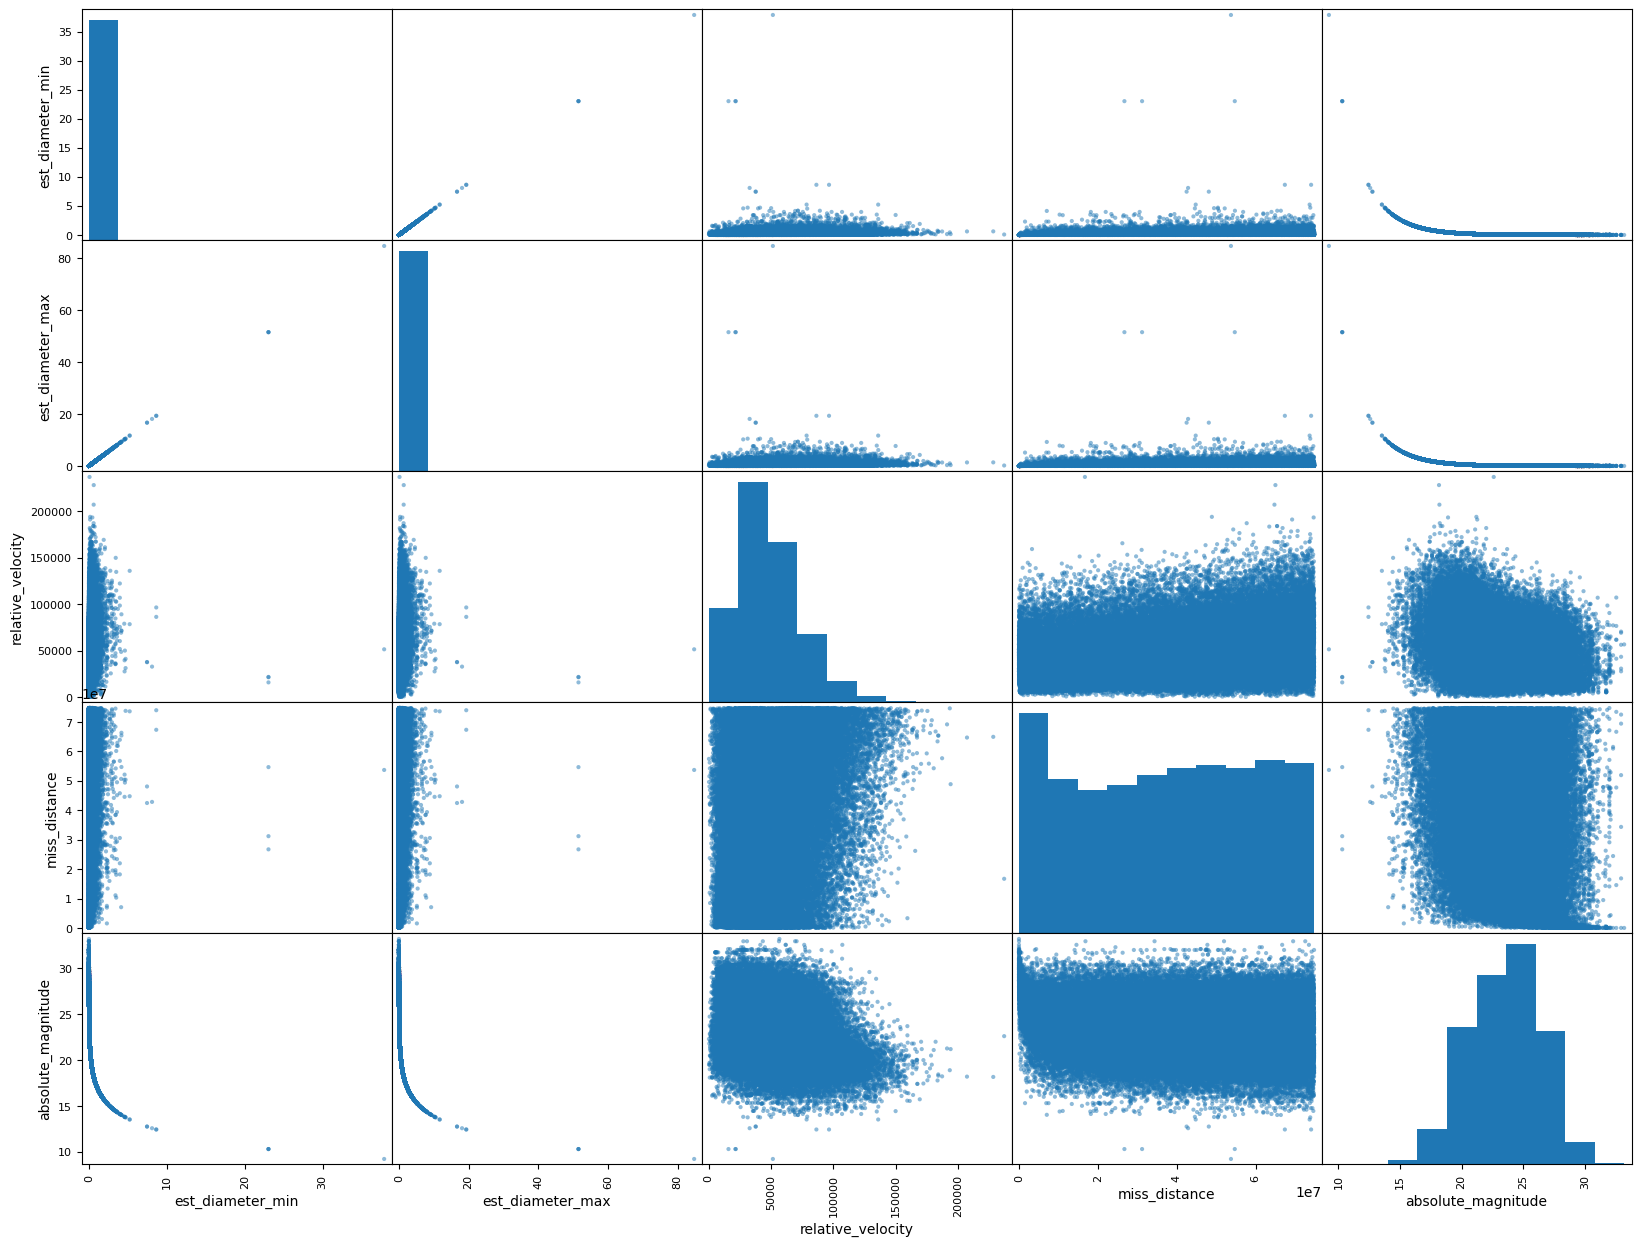

In [20]:
from pandas.plotting import scatter_matrix
attributes = ["est_diameter_min", "est_diameter_max", "relative_velocity","miss_distance", "absolute_magnitude"]
axes = scatter_matrix(prep_df[attributes], figsize=(20, 15))
axes[0,0].get_figure().show()

<Axes: xlabel='est_diameter_min', ylabel='est_diameter_max'>

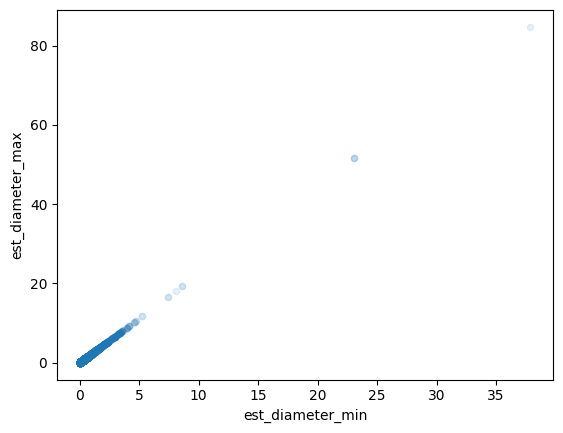

In [21]:
# The correlation of est_diameter_min and est_diameter_max seems suspicious, let's investigate
prep_df.plot(kind="scatter", x="est_diameter_min", y="est_diameter_max", alpha=0.1)

In [22]:
# Since the graph is perfectly linear 
prep_df[prep_df['est_diameter_min']!=prep_df['est_diameter_max']]

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1
...,...,...,...,...,...,...
90831,0.026580,0.059435,52078.886692,1.230039e+07,25.00,0
90832,0.016771,0.037501,46114.605073,5.432121e+07,26.00,0
90833,0.031956,0.071456,7566.807732,2.840077e+07,24.60,0
90834,0.007321,0.016370,69199.154484,6.869206e+07,27.80,0


In [23]:
corr_matrix['est_diameter_min'] 

est_diameter_min      1.000000
est_diameter_max      1.000000
relative_velocity     0.221553
miss_distance         0.142241
absolute_magnitude   -0.560188
hazardous             0.183363
Name: est_diameter_min, dtype: float64

In [24]:
# We can see that est_diameter_min and est_diameter_max have a correlation of 1 therefore we can keep one of those features
prep_df = prep_df.drop(columns=['est_diameter_max'])

In [25]:
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=21)
for train_index, test_index in strat_shuff_split.split(prep_df, prep_df["hazardous"]):
    x_train = prep_df.loc[train_index].iloc[:,:-1]
    y_train = prep_df.loc[train_index].iloc[:,-1:]['hazardous']
    x_test = prep_df.loc[test_index].iloc[:,:-1]
    y_test = prep_df.loc[test_index].iloc[:,-1:]['hazardous']

In [26]:
#lets also make a split without stratified sampling
x_train_nss, x_test_nss, y_train_nss, y_test_nss = train_test_split(prep_df.iloc[:,:-1], prep_df["hazardous"], test_size = 0.2, random_state = 21)

3. Prepare Data for ML Algorithms

3.1 Check for missing values. 

-> As we saw in our quick glance on the data there are no missing values therefore we can skip this step

3.2 Handling Text / Categorical Data

-> The Categorical Data was consisting of single categories therefore they were removed.

3.3 Feature Scaling

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(x_train)
x_train.iloc[:,:] = scaler.fit_transform(x_train.iloc[:,:].to_numpy())
x_test.iloc[:,:] = scaler.transform(x_test.iloc[:,:].to_numpy())

In [28]:
scaler = StandardScaler()
scaler.fit_transform(x_train_nss)
x_train_nss.iloc[:,:] = scaler.fit_transform(x_train_nss.iloc[:,:].to_numpy())
x_test_nss.iloc[:,:] = scaler.transform(x_test_nss.iloc[:,:].to_numpy())

4. Select and Train a Model

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [32]:
for x in ["recall", "precision", "f1", "accuracy"]:
    lr_clf = LogisticRegression()
    lr_clf.fit(x_train_nss, y_train_nss)
    print(cross_val_score(lr_clf, x_train_nss, y_train_nss, scoring=x, cv=5))

[0.06837607 0.06908832 0.06766382 0.07769066 0.08267997]
[0.42290749 0.47317073 0.4679803  0.45798319 0.57425743]
[0.11771919 0.12057178 0.11823273 0.13284583 0.14454829]
[0.90099078 0.90264208 0.90250447 0.90208491 0.90552536]


In [33]:
for x in ["recall", "precision", "f1", "accuracy"]:
    lr_clf = LogisticRegression()
    lr_clf.fit(x_train,y_train)
    print(cross_val_score(lr_clf, x_train, y_train, scoring=x, cv=5))

[0.07850071 0.06713781 0.06572438 0.06577086 0.07142857]
[0.51388889 0.43577982 0.4266055  0.42081448 0.47641509]
[0.13619632 0.11635028 0.1139008  0.11376147 0.12423124]
[0.90312371 0.90071556 0.90044035 0.90029588 0.9020161 ]


In [34]:
for x in ["recall", "precision", "f1", "accuracy"]:
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(x_train_nss,y_train_nss)
    print(cross_val_score(knn_clf, x_train_nss, y_train_nss, scoring=x, cv=5))

[0.27706553 0.30911681 0.31980057 0.27797577 0.29508197]
[0.46254459 0.47692308 0.46673597 0.47101449 0.47695853]
[0.34654788 0.37510804 0.37954353 0.349619   0.36459709]
[0.89906426 0.90050915 0.89899546 0.90015826 0.90070873]


In [35]:
for x in ["recall", "precision", "f1", "accuracy"]:
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(x_train,y_train)
    print(cross_val_score(knn_clf, x_train, y_train, scoring=x, cv=5))

[0.33239038 0.2975265  0.30600707 0.28925035 0.2970297 ]
[0.48403708 0.47732426 0.46760259 0.47447796 0.46614872]
[0.39412998 0.36656508 0.36992738 0.35940246 0.36285097]
[0.90057796 0.89988991 0.89851383 0.8996766  0.89850685]


In [36]:
for x in ["recall", "precision", "f1", "accuracy"]:
    rfc_clf = RandomForestClassifier(max_depth=3, random_state=0)
    rfc_clf.fit(x_train_nss,y_train_nss)
    print(cross_val_score(rfc_clf, x_train_nss, y_train_nss, scoring=x, cv=5))

[0.12321937 0.13817664 0.13176638 0.10691376 0.13043478]
[0.84390244 0.79835391 0.79741379 0.81081081 0.89705882]
[0.2150404  0.23557984 0.22616137 0.18891688 0.22775358]
[0.91310032 0.91337553 0.9128939  0.91137411 0.91460813]


In [37]:
for x in ["recall", "precision", "f1", "accuracy"]:
    rfc_clf = RandomForestClassifier(max_depth=3, random_state=0)
    rfc_clf.fit(x_train,y_train)
    print(cross_val_score(rfc_clf, x_train, y_train, scoring=x, cv=5))

[0.14002829 0.12720848 0.13992933 0.11739745 0.11103253]
[0.80161943 0.85308057 0.7983871  0.82587065 0.82198953]
[0.2384106  0.22140221 0.23812387 0.20557276 0.19563863]
[0.91296271 0.9128939  0.9128251  0.91171816 0.91116769]


In [38]:
for x in ["recall", "precision", "f1", "accuracy"]:
    xgb_clf = xgb.XGBClassifier(n_estimators=1000, max_depth=3)
    xgb_clf.fit(x_train_nss,y_train_nss)
    print(cross_val_score(xgb_clf, x_train_nss, y_train_nss, scoring=x, cv=5))

[0.31339031 0.32122507 0.32122507 0.28225232 0.29650748]
[0.63675832 0.66421208 0.63431786 0.61205564 0.67532468]
[0.42004773 0.43302928 0.42647754 0.38634146 0.41208519]
[0.91640292 0.91874226 0.91654053 0.91343838 0.91832381]


In [39]:
for x in ["recall", "precision", "f1", "accuracy"]:
    xgb_clf = xgb.XGBClassifier(n_estimators=1000, max_depth=3)
    xgb_clf.fit(x_train,y_train)
    print(cross_val_score(xgb_clf, x_train, y_train, scoring=x, cv=5))

[0.34582744 0.30812721 0.31872792 0.28359264 0.30480905]
[0.63921569 0.65171898 0.640625   0.62754304 0.64714715]
[0.44882974 0.4184261  0.42567249 0.39064783 0.41442308]
[0.91736618 0.91660933 0.91626531 0.91392004 0.91619074]


Let's move forward with XGBoost since it has the best Recall / Precision / f1 score ratio

5. Fine Tune the Model with Grid Search

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': [3, 10, 100, 1000, 2500],
    'learning_rate': [0.01,0.1, 0.05, 0.1, 0.3, 0.5]
}
xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring="recall", return_train_score=True)
grid_search.fit(x_train,y_train) 

In [ ]:
from sklearn.metrics import recall_score
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(x_test)
final_recall = recall_score(y_test, final_predictions, average='binary')
final_recall

Next Steps: Launch, Monitor and Maintain